# 19.3 Cumulative Gain Curves

**Chapter**: 19 - Evaluating Causal Models  
**Section**: 3 - Cumulative Gain Curves  
**Facure Source**: 19-Evaluating-Causal-Models.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-16

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [From Bands to Curves](#11-from-bands-to-curves)
   - 1.2 [The Cumulative Idea](#12-the-cumulative-idea)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Cumulative Sensitivity Curve](#21-cumulative-sensitivity-curve)
   - 2.2 [Cumulative Gain Curve](#22-cumulative-gain-curve)
3. [Implementation](#3-implementation)
4. [Numeric Demonstration](#4-numeric-demonstration)
5. [Confidence Intervals](#5-confidence-intervals)
6. [Interview Appendix](#6-interview-appendix)
7. [References](#7-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, stats,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    apply_tufte_style,
    TUFTE_PALETTE,
    COLORS,
)

import statsmodels.formula.api as smf
from sklearn.ensemble import GradientBoostingRegressor
from toolz import curry
import warnings
warnings.filterwarnings('ignore')

set_notebook_style()
np.random.seed(123)

print("Imports loaded successfully")

Imports loaded successfully


---

## 1. Facure's Intuition

> **Interview Relevance**: The cumulative gain curve is the causal equivalent of the ROC curve. Understanding this is essential for applied causal work.

### 1.1 From Bands to Curves

The sensitivity-by-band approach shows **discrete** buckets. But we want:
1. A **continuous** evaluation
2. A **single metric** to compare models

The **cumulative gain curve** provides both.

### 1.2 The Cumulative Idea

1. **Sort** units by predicted CATE (highest first)
2. **Accumulate**: For each k from 1 to N:
   - Take the top k units
   - Estimate their average treatment effect
3. **Plot**: k/N on x-axis, cumulative effect on y-axis

```
Cumulative Sensitivity Curve ────────────────────────────

  Y-axis: Sensitivity of top k% units
  X-axis: % of population (top k%)
  
  Good model: 
    - Starts HIGH (top units have high effect)
    - Slowly decreases toward ATE
    
  Random model:
    - Flat line at ATE
    - No ordering ability
─────────────────────────────────────────────────────────
```

In [2]:
# Load and prepare data
prices = load_facure_data('ice_cream_sales.csv')  # Non-random (training)
prices_rnd = load_facure_data('ice_cream_sales_rnd.csv')  # Random (evaluation)

# Build models
X = ["temp", "weekday", "cost", "price"]
y = "sales"

# CATE model
m1 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=prices).fit()

# Predictive model
m2 = GradientBoostingRegressor(max_depth=5, n_estimators=100, random_state=42)
m2.fit(prices[X], prices[y])

# Generate predictions
def predict_sensitivity(model, df, h=0.01):
    df_plus = df.copy()
    df_plus['price'] = df['price'] + h
    return (model.predict(df_plus) - model.predict(df)) / h

prices_rnd_pred = prices_rnd.copy()
prices_rnd_pred['sensitivity_m_pred'] = predict_sensitivity(m1, prices_rnd)
prices_rnd_pred['pred_m_pred'] = m2.predict(prices_rnd[X])
prices_rnd_pred['rand_m_pred'] = np.random.uniform(size=len(prices_rnd))

print("Data and models ready for evaluation.")

Data and models ready for evaluation.


---

## 2. Formal Treatment

### 2.1 Cumulative Sensitivity Curve

For the top k units (sorted by predicted CATE), the **cumulative sensitivity** is:

$$\hat{\tau}_k = \frac{\sum_{i=1}^{k}(T_i - \bar{T})(Y_i - \bar{Y})}{\sum_{i=1}^{k}(T_i - \bar{T})^2}$$

**Properties**:
- At k = N (all units): $\hat{\tau}_N$ = overall ATE
- Good model: $\hat{\tau}_1 > \hat{\tau}_2 > ... > \hat{\tau}_N$

### 2.2 Cumulative Gain Curve

The **cumulative gain** normalizes by sample proportion:

$$G_k = \hat{\tau}_k \times \frac{k}{N}$$

**Why normalize?**
- All curves start at 0 and end at ATE
- Easier to compare models visually
- Random model = straight line from (0,0) to (1, ATE)

**Interpretation**:
- X-axis: Fraction of population treated
- Y-axis: Total gain (effect × proportion)

---

## 3. Implementation

In [3]:
@curry
def sensitivity(data, y, t):
    """Estimate sensitivity (slope) using simple linear regression."""
    t_bar = data[t].mean()
    y_bar = data[y].mean()
    cov = np.sum((data[t] - t_bar) * (data[y] - y_bar))
    var = np.sum((data[t] - t_bar) ** 2)
    return cov / var if var > 0 else 0

def cumulative_sensitivity_curve(dataset, prediction, y, t, min_periods=30, steps=100):
    """
    Compute cumulative sensitivity curve.
    
    Parameters
    ----------
    dataset : DataFrame
    prediction : str, column with predictions (higher = higher expected effect)
    y : str, outcome column
    t : str, treatment column
    min_periods : int, minimum sample size to start
    steps : int, number of points on curve
    
    Returns
    -------
    array : cumulative sensitivity at each point
    """
    size = dataset.shape[0]
    
    # Sort by prediction (highest first)
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    
    # Create sequence of sample sizes
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # Compute cumulative sensitivity at each point
    return np.array([sensitivity(ordered_df.head(rows), y, t) for rows in n_rows])

# Test
overall_sens = sensitivity(prices_rnd_pred, 'sales', 'price')
print(f"Overall sensitivity (ATE): {overall_sens:.3f}")

Overall sensitivity (ATE): -2.552


In [4]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    """
    Compute cumulative gain curve.
    
    Same as cumulative sensitivity but multiplied by (k/N).
    
    Returns
    -------
    array : cumulative gain at each point
    """
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # Add normalization factor (rows/size)
    return np.array([sensitivity(ordered_df.head(rows), y, t) * (rows/size) 
                     for rows in n_rows])

# Test
gain_test = cumulative_gain(prices_rnd_pred, 'sensitivity_m_pred', 'sales', 'price')
print(f"Cumulative gain curve computed: {len(gain_test)} points")
print(f"Final value (should ≈ ATE): {gain_test[-1]:.3f}")

Cumulative gain curve computed: 101 points
Final value (should ≈ ATE): -2.552


---

## 4. Numeric Demonstration

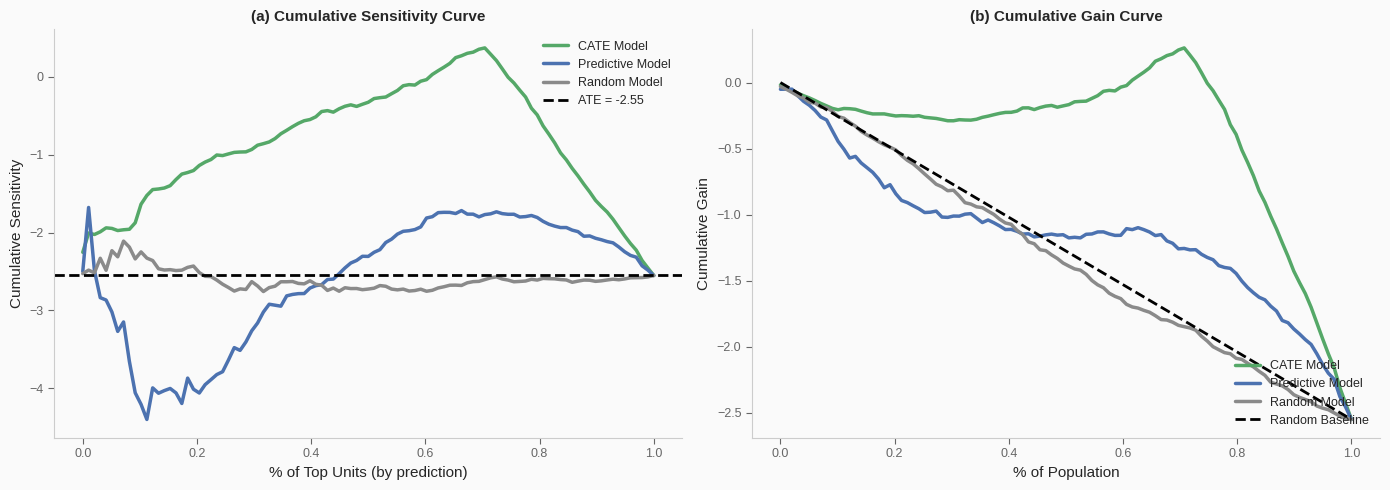

In [5]:
# Compute cumulative sensitivity curves for all models
fig, axes = create_tufte_figure(1, 2, figsize=(14, 5))

models = ['sensitivity_m_pred', 'pred_m_pred', 'rand_m_pred']
names = ['CATE Model', 'Predictive Model', 'Random Model']
colors = [COLORS['green'], COLORS['blue'], TUFTE_PALETTE['secondary']]

# Panel 1: Cumulative Sensitivity Curve
ax = axes[0]
for model, name, color in zip(models, names, colors):
    curve = cumulative_sensitivity_curve(prices_rnd_pred, model, 'sales', 'price', 
                                         min_periods=100, steps=100)
    x = np.linspace(0, 1, len(curve))
    ax.plot(x, curve, c=color, lw=2.5, label=name)

ax.axhline(overall_sens, color='black', linestyle='--', lw=2, label=f'ATE = {overall_sens:.2f}')
ax.set_xlabel('% of Top Units (by prediction)', fontsize=11)
ax.set_ylabel('Cumulative Sensitivity', fontsize=11)
ax.set_title('(a) Cumulative Sensitivity Curve', fontweight='bold')
ax.legend(frameon=False, loc='upper right')

# Panel 2: Cumulative Gain Curve
ax = axes[1]
for model, name, color in zip(models, names, colors):
    curve = cumulative_gain(prices_rnd_pred, model, 'sales', 'price', 
                            min_periods=50, steps=100)
    x = np.linspace(0, 1, len(curve))
    ax.plot(x, curve, c=color, lw=2.5, label=name)

# Random baseline (straight line)
ax.plot([0, 1], [0, overall_sens], 'k--', lw=2, label='Random Baseline')

ax.set_xlabel('% of Population', fontsize=11)
ax.set_ylabel('Cumulative Gain', fontsize=11)
ax.set_title('(b) Cumulative Gain Curve', fontweight='bold')
ax.legend(frameon=False, loc='lower right')

plt.tight_layout()
plt.show()

In [6]:
# Interpretation
print("=" * 60)
print("INTERPRETATION")
print("=" * 60)
print("""
(a) Cumulative Sensitivity Curve:
    - CATE model (green): Starts negative, converges to ATE
      -> Top units have the most negative sensitivity (high price effect)
    - Predictive model (blue): Starts near ATE, stays flat
      -> No ability to order by sensitivity
    - Random (gray): Flat at ATE throughout
      -> Expected for random ordering

(b) Cumulative Gain Curve:
    - CATE model: Below the random line, then crosses
      -> Can identify high-sensitivity units (more negative = better for pricing)
    - Predictive and Random: Follow the diagonal
      -> No gain over random targeting
""")

INTERPRETATION

(a) Cumulative Sensitivity Curve:
    - CATE model (green): Starts negative, converges to ATE
      -> Top units have the most negative sensitivity (high price effect)
    - Predictive model (blue): Starts near ATE, stays flat
      -> No ability to order by sensitivity
    - Random (gray): Flat at ATE throughout
      -> Expected for random ordering

(b) Cumulative Gain Curve:
    - CATE model: Below the random line, then crosses
      -> Can identify high-sensitivity units (more negative = better for pricing)
    - Predictive and Random: Follow the diagonal
      -> No gain over random targeting



In [7]:
# Compute AUUC (Area Under Uplift Curve)
def auuc(dataset, prediction, y, t, min_periods=30, steps=100):
    """
    Compute Area Under Uplift Curve.
    
    Higher = better at ordering units by treatment effect.
    """
    curve = cumulative_gain(dataset, prediction, y, t, min_periods, steps)
    x = np.linspace(0, 1, len(curve))
    return np.trapezoid(curve, x)

print("=" * 60)
print("AREA UNDER UPLIFT CURVE (AUUC)")
print("=" * 60)
print("\nHigher value = better at ordering units by treatment effect")
print(f"Random baseline: {0.5 * overall_sens:.4f}")
print()

for model, name in zip(models, names):
    auuc_val = auuc(prices_rnd_pred, model, 'sales', 'price')
    improvement = (auuc_val - 0.5 * overall_sens) / (0.5 * abs(overall_sens)) * 100
    print(f"{name}: AUUC = {auuc_val:.4f} ({improvement:+.1f}% vs random)")

AREA UNDER UPLIFT CURVE (AUUC)

Higher value = better at ordering units by treatment effect
Random baseline: -1.2758

CATE Model: AUUC = -0.4070 (+68.1% vs random)
Predictive Model: AUUC = -1.1468 (+10.1% vs random)
Random Model: AUUC = -1.3326 (-4.5% vs random)


In [8]:
# Note: For price sensitivity, more negative is "better" (more sensitive)
# Let's flip the sign for a cleaner interpretation
print("\nNote: For price sensitivity, we want to identify the MOST NEGATIVE effect.")
print("The CATE model correctly identifies units where price increases hurt sales most.")
print("\nThis is useful for:")
print("  - Keeping prices LOW on high-sensitivity days")
print("  - Raising prices on low-sensitivity days")


Note: For price sensitivity, we want to identify the MOST NEGATIVE effect.
The CATE model correctly identifies units where price increases hurt sales most.

This is useful for:
  - Keeping prices LOW on high-sensitivity days
  - Raising prices on low-sensitivity days


---

## 5. Confidence Intervals

We should account for sampling variability in our estimates.

In [9]:
def sensitivity_ci(df, y, t, z=1.96):
    """
    Compute confidence interval for sensitivity estimate.
    
    Uses standard OLS formula for the slope CI.
    """
    n = df.shape[0]
    t_bar = df[t].mean()
    beta1 = sensitivity(df, y, t)
    beta0 = df[y].mean() - beta1 * t_bar
    
    # Residuals
    e = df[y] - (beta0 + beta1 * df[t])
    
    # Standard error of beta1
    se = np.sqrt(((1 / (n - 2)) * np.sum(e ** 2)) / np.sum((df[t] - t_bar) ** 2))
    
    return np.array([beta1 - z * se, beta1 + z * se])

def cumulative_gain_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    """
    Compute cumulative gain curve with confidence intervals.
    """
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    return np.array([sensitivity_ci(ordered_df.head(rows), y, t) * (rows / size) 
                     for rows in n_rows])

# Test
ci = sensitivity_ci(prices_rnd_pred, 'sales', 'price')
print(f"Overall sensitivity: {overall_sens:.3f}")
print(f"95% CI: [{ci[0]:.3f}, {ci[1]:.3f}]")

Overall sensitivity: -2.552
95% CI: [-2.799, -2.304]


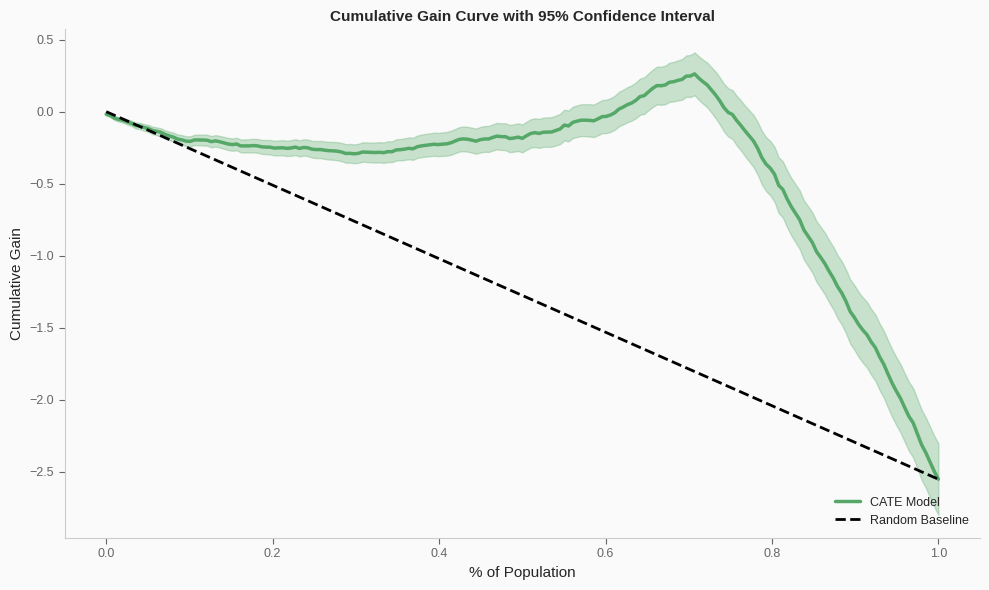


CI gets NARROWER as we include more data (right side of curve).
CI is WIDER at the start (small sample size, noisier estimates).


In [10]:
# Plot with confidence intervals
fig, ax = create_tufte_figure(1, 1, figsize=(10, 6))

# Compute curve with CI
gain_ci = cumulative_gain_ci(prices_rnd_pred, 'sensitivity_m_pred', 'sales', 'price', 
                             min_periods=50, steps=200)
x = np.linspace(0, 1, len(gain_ci))

# Plot CI as shaded region
ax.fill_between(x, gain_ci[:, 0], gain_ci[:, 1], alpha=0.3, color=COLORS['green'])
ax.plot(x, (gain_ci[:, 0] + gain_ci[:, 1]) / 2, c=COLORS['green'], lw=2.5, label='CATE Model')

# Random baseline
ax.plot([0, 1], [0, overall_sens], 'k--', lw=2, label='Random Baseline')

ax.set_xlabel('% of Population', fontsize=11)
ax.set_ylabel('Cumulative Gain', fontsize=11)
ax.set_title('Cumulative Gain Curve with 95% Confidence Interval', fontweight='bold')
ax.legend(frameon=False, loc='lower right')

plt.tight_layout()
plt.show()

print("\nCI gets NARROWER as we include more data (right side of curve).")
print("CI is WIDER at the start (small sample size, noisier estimates).")

```
Key Takeaways ───────────────────────────────────────────

1. Cumulative Sensitivity Curve
   - Shows sensitivity of top k% units
   - Good model: starts extreme, converges to ATE
   - Random model: flat at ATE

2. Cumulative Gain Curve
   - Normalized: gain × proportion
   - All curves: 0 to ATE
   - Random baseline: diagonal line
   - "ROC curve for causal inference"

3. AUUC (Area Under Uplift Curve)
   - Single metric for comparison
   - Higher = better ordering ability
   - Compare to random baseline
   
4. Confidence Intervals
   - Use OLS formula for slope CI
   - Multiply by (k/N) for gain CI
   - Important for small samples
─────────────────────────────────────────────────────────
```

---

## 6. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"Explain the cumulative gain curve for CATE model evaluation."*

<details>
<summary>Solution</summary>

**The cumulative gain curve**:

1. **Sort** units by predicted CATE (highest first)
2. **For each k** from 1 to N:
   - Take top k units
   - Estimate their treatment effect: $\hat{\tau}_k$
   - Compute gain: $G_k = \hat{\tau}_k \times (k/N)$
3. **Plot**: X = k/N, Y = $G_k$

**Properties**:
- All curves start at (0, 0)
- All curves end at (1, ATE)
- Random model: straight diagonal line

**Interpretation**:
- Area above random line = model's ability to find high-effect units
- Curves that diverge more from diagonal = better models

**Analogy**: Like ROC curve for classification, but for causal effect ordering.

**Metric**: AUUC (Area Under Uplift Curve) summarizes the curve.

</details>

---

**Q2 (Amazon L6, Econ)**: *"What is the relationship between cumulative gain curve and the Qini curve?"*

<details>
<summary>Solution</summary>

**Qini curve** (original, for binary treatment):
- Sort by predicted uplift
- Plot: treated outcome - control outcome (normalized)
- Popular in uplift modeling literature

**Cumulative gain curve** (generalized):
- Works for continuous treatment (via regression slope)
- Same principle: order by prediction, estimate actual effect
- More general framework

**Relationship**:
- Qini is the binary treatment version
- Cumulative gain extends to continuous treatments
- Both measure "ordering quality" for treatment targeting

**Key insight**: The normalization (multiplying by k/N) ensures:
- All curves start at 0 and end at ATE
- Random baseline is a straight line
- Easier visual comparison

</details>

---

**Q3 (Google L5, Quant)**: *"How do you compute confidence intervals for the cumulative gain curve?"*

<details>
<summary>Solution</summary>

**For each point k on the curve**:

1. **Estimate sensitivity** in top k units:
   $$\hat{\tau}_k = \text{Cov}(T, Y) / \text{Var}(T)$$

2. **Standard error** (OLS formula):
   $$SE(\hat{\tau}_k) = \sqrt{\frac{\sum e_i^2 / (n-2)}{\sum (T_i - \bar{T})^2}}$$
   where $e_i = Y_i - (\hat{\beta}_0 + \hat{\tau}_k T_i)$

3. **Confidence interval for sensitivity**:
   $$\hat{\tau}_k \pm z_{\alpha/2} \times SE(\hat{\tau}_k)$$

4. **Cumulative gain CI** (multiply by k/N):
   $$(\hat{\tau}_k \pm z \times SE) \times \frac{k}{N}$$

**Properties**:
- CI is **wide** at small k (few observations)
- CI **narrows** as k increases
- At k = N: CI for overall ATE

**Alternative**: Bootstrap the entire curve for non-parametric CI.

</details>

---

## 7. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 19: "Evaluating Causal Models."

[^2]: Gutierrez, P. and Gérardy, J. Y. (2017). Causal Inference and Uplift Modeling: A Review of the Literature. *JMLR Workshop and Conference Proceedings*, 67, 1-13.

[^3]: Radcliffe, N. J. (2007). Using Control Groups to Target on Predicted Lift. *Direct Market Journal*, 3, 14-21.

[^4]: Breiman, L. (2001). Statistical Modeling: The Two Cultures. *Statistical Science*, 16(3), 199-231.

---

**Chapter Complete**: You now have tools to build AND evaluate CATE models!